(36415, 2)
(4, 36415)


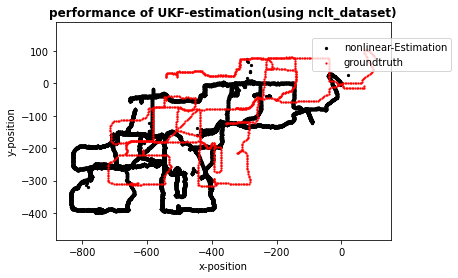

In [1]:
import numpy as np
import scipy
from numpy.random import randn
import numpy as np
import scipy
from scipy.linalg import sqrtm
import scipy.interpolate
import math
import matplotlib.pyplot as plt
import csv

def parameter_sigmapoints(n, alpha, beta, kappa):
    '''
    n : dimension of state vector
    alpha,beta,kappa : manually set up patamaters
    wm : weight matrix for calculating mean
    wc : weight matrix for calculating variance
    U : a parameter for computation convenience
    '''
    lamb = alpha ** 2 * (n + kappa) - n
    wm = [lamb / (n + lamb)]
    wc = [(lamb / (lamb + n)) + (1 - alpha ** 2 + beta)]
    for i in range(2 * n):
        wm.append(1 / (2 * (n + lamb)))
        wc.append(1 / (2 * (n + lamb)))
    U = math.sqrt(n + lamb)
    U = np.array([U])
    wm = np.array([wm])
    wc = np.array([wc])
    return wm, wc, U


def generate_sigmapoints(xEst, PEst, U):
    '''
    xEst:mean of initial data
    PEst:variance of initial data
    U:U=sqrt(n+lamb)
    '''
    sigma = xEst
    Psqrt = scipy.linalg.sqrtm(PEst)
    # Psqrt=scipy.linalg.cholesky(PEst)
    n = len(xEst[:, 0])
    for i in range(n):
        sigma = np.hstack((sigma, xEst + U * Psqrt[:, i:i + 1]))
    for i in range(n):
        sigma = np.hstack((sigma, xEst - U * Psqrt[:, i:i + 1]))
    return sigma


def transform_sigma_motion(sigma):
    """
        Sigma Points prediction with motion model
    """
    for i in range(sigma.shape[1]):
        sigma[:, i:i + 1] = f(sigma[:, i:i + 1], dt)

    return sigma


def transform_sigma_observation(sigma):
    """
        Sigma Points prediction with observation model
    """
    sigma_obs = np.zeros((2, sigma.shape[1]))
    for i in range(sigma.shape[1]):
        sigma_obs[:, i] = h(sigma[:, i])
    return sigma_obs


def covariance_prior(x, sigma, wc, Pi):
    '''

    '''
    nSigma = sigma.shape[1]

    d = sigma - x[0:sigma.shape[0]]
    # print('d ist',d)
    P = Pi
    for i in range(nSigma):
        P = P + wc[0, i] * d[:, i:i + 1] @ d[:, i:i + 1].T
    return P


def calc_pxz(sigma, x, z_sigma, zb, wc):
    '''

    '''
    nSigma = sigma.shape[1]
    dx = sigma - x
    dz = z_sigma - zb[0:2]
    P = np.zeros((dx.shape[0], dz.shape[0]))

    for i in range(nSigma):
        P = P + wc[0, i] * dx[:, i:i + 1] @ dz[:, i:i + 1].T
    return P


def ukf_estimation(xEst, PEst, z, wm, wc, gamma):
    '''
    z: observation with noise
    wm, wc, gamma: constant parameters
    '''
    #  Predict process
    # generate sigma points
    sigma = generate_sigmapoints(xEst, PEst, gamma)
    sigma = transform_sigma_motion(sigma)
    # prediction of mean of input
    xPred = (wm @ sigma.T).T
    # estimate of covariance
    PPred = covariance_prior(xPred, sigma, wc, Q)

    #  Update process

    #  generate new sigma points after prediction
    sigma = generate_sigmapoints(xPred, PPred, gamma)
    # transform sigma points with observation model
    z_sigma = transform_sigma_observation(sigma)
    # mean
    zPred = (wm @ z_sigma.T).T
    #  Pz_matrix
    st = covariance_prior(zPred, z_sigma, wc, R)
    Pxz = calc_pxz(sigma, xPred, z_sigma, zPred, wc)
    # kalman gain
    K = Pxz @ np.linalg.inv(st)
    y = z - zPred
    # update the estimate value：
    xEst = xPred + K @ y
    # update the covariance：
    PEst = PPred - K @ st @ K.T
    return xEst, PEst


def f(x, dt):
    '''
    state vector[x,y,x_dot,y_dot]
    accelaration(or control input) is modified as a gaussian noise process
    '''
    A = np.array([[0, 0, dt, 0],
                  [0, 0, 0, dt],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0]])
    B = np.array([[0, 0],
                  [0, 0],
                  [dt, 0],
                  [0, dt]])
    U = np.zeros(shape=(2, 1))
    U[0:1, 0:1] = np.random.normal(0, 0.02, size=(1, 1))
    U[1:2, 0:1] = np.random.normal(0, 0.02, size=(1, 1))

    return np.dot(A, x) + np.dot(B, U) + x


def h(x):
    '''
    observation model,position x y is the noisy reading
    '''
    H = np.array([[1, 0, 0, 0],
                  [0, 1, 0,0 ]])
    return np.dot(H, x)


# time step
dt = 1
# parameter q and r of the covariance of matrix Q and R, which can be optimized through a grid search
q = 1
r = 1

Q = np.array([dt, dt, dt, dt])
Q = q ** 2 * np.diag(Q)
R = np.diag([r, r]) ** 2

# read the absolute velocity of the robot using the wheel velocity file
# v=0.5*(v_right+v_left)

with open('C:/Users/85193/pythonProject1/gps.csv','r') as csvfile:
    reader = csv.reader(csvfile)
    rows= [row for row in reader]
    gps = np.array(rows).astype(float)

num_sats = gps[:, 2]
lat = gps[:, 3]
lng = gps[:, 4]
alt = gps[:, 5]

lat0 = lat[0]
lng0 = lng[0]

dLat = lat - lat0
dLng = lng - lng0

r = 6400000 # approx. radius of earth (m)
pos_x = r * np.cos(lat0) * np.sin(dLng).reshape(36415,1)
pos_y = r * np.sin(dLat).reshape(36415,1)
position=np.append(pos_x,pos_y,axis=1) #z.shape=(500,2)
print(position.shape)

#xEst = np.zeros((4, 1)).reshape(4, 1)  # default initial state
#xEst = np.array([0,0,0,0]).reshape(4,1)
xEst = np.array([79,104,0,0]).reshape(4,1)
n = 4  # dimension of State Vector [x x_dot y y_dot]'
PEst = np.eye(n)  # initial of the covariance matrix
alpha = .1
beta = 2.
kappa = 1.
wm, wc, gamma = parameter_sigmapoints(n, alpha, beta, kappa)
hxEst = xEst

for i in range(36414):
    # np.random.seed()
    z = np.array(position[i, :]).reshape(2, 1)
    xEst, PEst = ukf_estimation(xEst, PEst, z, wm, wc, gamma)
    hxEst = np.hstack((hxEst, xEst))
print(hxEst.shape)

plt.figure(1)
plt.scatter(hxEst[0, :], hxEst[1, :], color='black', s=5, label="nonlinear-Estimation")
plt.title('performance of UKF-estimation(using nclt_dataset)', fontsize='large', fontweight='bold')
plt.xlabel('x-position')
plt.ylabel('y-position')


with open('C:/Users/85193/pythonProject1/groundtruth.csv','r') as csvfile:
    reader = csv.reader(csvfile)
    rows= [row for row in reader]
    gt = np.array(rows).astype(float)

with open('C:/Users/85193/pythonProject1/covariance.csv','r') as csvfile:
    reader = csv.reader(csvfile)
    rows = [row for row in reader]
    cov = np.array(rows)
t_cov = cov[:, 0]
interp = scipy.interpolate.interp1d(gt[:, 0].astype(float), gt[:, 1:].astype(float), kind='nearest', axis=0,
                                        fill_value="extrapolate")
pose_gt = interp(t_cov)

# NED (North, East Down)
x_truth = pose_gt[:, 0].reshape(1221,1)
y_truth = pose_gt[:, 1].reshape(1221,1)
z_truth = pose_gt[:, 2]

r = pose_gt[:, 3]
p = pose_gt[:, 4]
h = pose_gt[:, 5]

plt.scatter(y_truth, x_truth, 5,color='red', linewidth=0,label="groundtruth")  # Note Z points down
plt.axis('equal')
plt.legend(loc='upper left', bbox_to_anchor=(0.75, 0.95))
plt.show()